# <font color='blue'> <center> ScalaAI</center> </font> 

## <center> Escalação Automática e Otimizada de Times do CartolaFC - 2021 </center> 
### Versão Teste - Escalação na Formação 4-3-3

<center><img src = "https://github.com/lucianogarim/ScalaAI/blob/main/sca.jpg?raw=true" height = "350" width="800"></center> 

Importação dos pacotes necessários

In [1]:
%pylab
%matplotlib inline
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


Leitura dos dados da API do CartolaFC

In [2]:
response = requests.get('https://api.cartolafc.globo.com/atletas/mercado')
data = json.loads(response.text)
atletas = pd.DataFrame(data['atletas'])
times = pd.DataFrame(data['clubes']).T

Remove as colunas desnecessárias

In [3]:
atletas.drop(['atleta_id','scout', 'slug', 'apelido_abreviado', 'nome', 'foto'],
             axis=1, inplace=True)
times.drop(['abreviacao', 'escudos', 'nome_fantasia'], axis=1, inplace=True)
atletas = atletas[['apelido', 'clube_id', 'posicao_id', 'preco_num', 'pontos_num',
                   'variacao_num', 'media_num', 'rodada_id', 'jogos_num','status_id']]

Organizando os dados

In [4]:
atletas.posicao_id = atletas.posicao_id.map({1:'Goleiro', 2:'Lateral', 3:'Zagueiro',
                                             4:'Meia', 5:'Atacante', 6:'Tecnico'})
times_id = times['id'].to_list()
times_nome = times['nome'].to_list()
dictionary = dict(zip(times_id, times_nome))
atletas.clube_id = atletas.clube_id.map(dictionary)
#renomeia as colunas
atletas.rename(columns={'clube_id': 'clube', 'posicao_id': 'posicao',
                        'preco_num': 'preco', 'pontos_num': 'pontos',
                        'variacao_num': 'variacao', 'media_num': 'media',
                        'rodada_id': 'rodada','jogos_num': 'jogos'}, inplace=True)

Considerando a escalação de apenas jogadores prováveis

In [5]:
atletas = atletas[atletas.status_id==7].reset_index()
atletas.drop(['index','status_id'], axis=1, inplace=True)
atletas.reset_index()

,index,apelido,clube,posicao,preco,pontos,variacao,media,rodada,jogos
0,0,Maurício Barbieri,Bragantino,Tecnico,13.12,1.94,-0.26,4.23,22,20
1,1,Nino Paraíba,Bahia,Lateral,8.35,4.10,-0.45,3.17,22,17
2,2,Patrick,Internacional,Meia,9.81,5.80,0.63,4.02,22,19
3,3,Ferreira,Grêmio,Atacante,10.18,5.80,-0.26,5.01,22,12
4,4,Cleiton,Bragantino,Goleiro,8.64,0.00,0.00,3.97,22,17
...,...,...,...,...,...,...,...,...,...,...
225,225,Douglas Friedrich,Juventude,Goleiro,6.08,8.00,1.38,4.00,22,2
226,226,Rodrigo Dourado,Internacional,Meia,8.23,9.20,0.95,3.81,22,15
227,227,Moisés,Internacional,Lateral,4.73,0.00,0.00,2.88,22,12
228,228,Saravia,Internacional,Lateral,7.71,0.00,0.00,4.98,22,12


# Algoritmo Genético para Escalação Automática

In [6]:
dados = pd.DataFrame(atletas[['apelido','media','posicao','preco','pontos','jogos']])
dados.index = dados.index.set_names(['id'])
dados = dados.reset_index()

best = 0
Goleiro = 1
Zagueiro = 2
Zagueiro = 3
Lateral = 4
Lateral = 5
Meia = 6
Meia = 7
Meia = 8
Atacante = 9
Atacante = 10
Atacante = 11
Tecnico = 12

# Aqui é possível alterar os pesos para definir qual a prioridade do seu time
peso_media = 0.5
peso_jogos = 0.25
peso_pontos = 0.25

score_atleta = ((dados.media/dados.media.max()) * peso_media 
                + (dados.jogos/dados.jogos.max()) * peso_jogos 
                + (dados.pontos/dados.pontos.max()) * peso_pontos)
dados['score_atleta'] = score_atleta


# População inicial
populacao = list(range(30))
for i in range(0,30):
    populacao[i]=[random.choice(dados.loc[dados.posicao=='Goleiro']['id']),
                  random.choice(dados.loc[dados.posicao=='Zagueiro']['id']),
                  random.choice(dados.loc[dados.posicao=='Zagueiro']['id']),
                  random.choice(dados.loc[dados.posicao=='Lateral']['id']),
                  random.choice(dados.loc[dados.posicao=='Lateral']['id']),
                  random.choice(dados.loc[dados.posicao=='Meia']['id']),
                  random.choice(dados.loc[dados.posicao=='Meia']['id']),
                  random.choice(dados.loc[dados.posicao=='Meia']['id']),
                  random.choice(dados.loc[dados.posicao=='Atacante']['id']),
                  random.choice(dados.loc[dados.posicao=='Atacante']['id']),
                  random.choice(dados.loc[dados.posicao=='Atacante']['id']),
                  random.choice(dados.loc[dados.posicao=='Tecnico']['id'])]
a = []
c = []
control = 0
while (control==0):
    # Função de custo
    for k in range(500):  # Aqui é possível alterar o número de iterações
        cartoletas = 125  # Pode alterar a quantidade de cartoletas disponíveis
        for i in range(0,shape(populacao)[0]):
            pontuacao = dados.iloc[populacao[i]].score_atleta.sum()/12
            c.append(pontuacao)
            if dados.iloc[populacao[i]].preco.sum() > cartoletas:
                populacao[i].append(100)
            else:
                populacao[i].append(pontuacao)
                if populacao[i][-1]>best:
                    best = populacao[i][-1]
                    melhor =  populacao[i]
                    a.append(populacao[i][-1])
    # Seleção
        caixa = populacao
        selecao = []
        for i in range(0,12):
            candidato1 = caixa[random.choice(len(caixa))]
            candidato2 = candidato1
            while (candidato1[0]==candidato2[0]):
                candidato2 = caixa[random.choice(len(caixa))]   

            if candidato1[-1]>candidato2[-1]:
                selecao.append(candidato1)
                caixa.remove(candidato1)
            else:
                selecao.append(candidato2)
                caixa.remove(candidato2)
    # Reprodução
        geracao = []
        while (len(selecao)!=0):
            candidato1 = selecao[random.choice(len(selecao))]
            candidato2 = candidato1
            while (candidato1==candidato2):
                candidato2 = selecao[random.choice(len(selecao))] 
            filho1 = candidato1[0:3]+candidato2[3:6]+candidato1[6:-1]
            pos = random.choice(len(filho1))
            if pos==Goleiro:
                filho1[pos] = random.choice(dados[dados.posicao=='Goleiro'].id)
            elif pos==Zagueiro:
                filho1[pos] = random.choice(dados[dados.posicao=='Zagueiro'].id)
            elif pos==Lateral:
                filho1[pos] = random.choice(dados[dados.posicao=='Lateral'].id)
            elif pos==Meia:
                filho1[pos] = random.choice(dados[dados.posicao=='Meia'].id)
            elif pos==Atacante:
                filho1[pos] = random.choice(dados[dados.posicao=='Atacante'].id)
            else:
                filho1[pos] = random.choice(dados[dados.posicao=='Tecnico'].id)

            filho2 = candidato2[0:3]+candidato1[3:6]+candidato2[6:-1]
            pos = random.choice(len(filho2))
            if pos==Goleiro:
                filho2[pos] = random.choice(dados[dados.posicao=='Goleiro'].id)
            elif pos==Zagueiro:
                filho2[pos] = random.choice(dados[dados.posicao=='Zagueiro'].id)
            elif pos==Lateral:
                filho2[pos] = random.choice(dados[dados.posicao=='Lateral'].id)
            elif pos==Meia:
                filho2[pos] = random.choice(dados[dados.posicao=='Meia'].id)
            elif pos==Atacante:
                filho2[pos] = random.choice(dados[dados.posicao=='Atacante'].id)
            else:
                filho2[pos] = random.choice(dados[dados.posicao=='Tecnico'].id)

            selecao.remove(candidato1)
            selecao.remove(candidato2)
            geracao.append(candidato1[:-1])
            geracao.append(candidato2[:-1])
    # Completa população
        populacao = list(range(18))
        for i in range(0,18):
            populacao[i]=[random.choice(dados.loc[dados.posicao=='Goleiro']['id']),
                          random.choice(dados.loc[dados.posicao=='Zagueiro']['id']),
                          random.choice(dados.loc[dados.posicao=='Zagueiro']['id']),
                          random.choice(dados.loc[dados.posicao=='Lateral']['id']),
                          random.choice(dados.loc[dados.posicao=='Lateral']['id']),
                          random.choice(dados.loc[dados.posicao=='Meia']['id']),
                          random.choice(dados.loc[dados.posicao=='Meia']['id']),
                          random.choice(dados.loc[dados.posicao=='Meia']['id']),
                          random.choice(dados.loc[dados.posicao=='Atacante']['id']),
                          random.choice(dados.loc[dados.posicao=='Atacante']['id']),
                          random.choice(dados.loc[dados.posicao=='Atacante']['id']),
                          random.choice(dados.loc[dados.posicao=='Tecnico']['id'])]

        populacao = populacao + geracao
    # Time escolhido    
    time = pd.DataFrame()
    for i in range(12):
        time = time.append(dados[dados.id==melhor[i]])

    if (time.duplicated().any()==True):
        control = 0
    else:
        control = 1

Score do Time: pontuação entre zero e um.

In [7]:
time.score_atleta.sum()/12

0.4800413525963149

Preço do Time

In [8]:
time.preco.sum()

118.50999999999999

Performance: score de todos os times gerados

Text(0, 0.5, 'Número de Iterações')

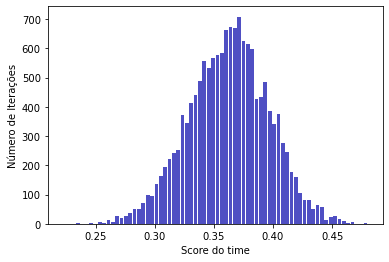

In [9]:
plt.hist(x=c, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.xlabel('Score do time')
plt.ylabel('Número de Iterações')

Performance: score dos melhores times ao longo das iterações (convergência)

Text(0.5, 0, 'Aumento do Score')

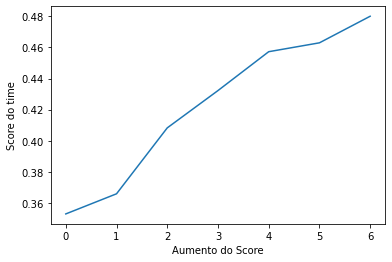

In [10]:
plot(a)
plt.ylabel('Score do time')
plt.xlabel('Aumento do Score')

O time escalado

In [11]:
time

,id,apelido,media,posicao,preco,pontos,jogos,score_atleta
70,70,Daniel,5.12,Goleiro,8.71,7.00,19,0.552741
7,7,Víctor Cuesta,3.27,Zagueiro,8.80,7.80,20,0.480231
75,75,Gabriel Lacerda,3.71,Zagueiro,5.13,5.00,13,0.390978
198,198,Fagner,3.82,Lateral,11.61,0.70,21,0.438551
113,113,Vanderson,5.32,Lateral,12.06,15.70,15,0.616200
189,189,Terans,5.50,Meia,11.46,0.00,18,0.480927
38,38,Nikão,4.76,Meia,10.71,12.20,14,0.536923
2,2,Patrick,4.02,Meia,9.81,5.80,19,0.483828
80,80,Mike,1.83,Atacante,2.35,2.70,15,0.293096
203,203,Marinho,5.05,Atacante,16.81,3.10,14,0.448087
